In [134]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from nltk.tokenize import word_tokenize
from nltk import pos_tag

%matplotlib inline
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

import emoji
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

### Init lists for the analysis

HAPPY = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P'
    , ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

SAD = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])
dt = ['not', 'no', 'for', 'and', 'nor', 'but', 'or', 'so',
        'while', 'if', 'only', 
        'until', 'than', 
         'as', 'after', 'before',
        'by', 'now', 'once',
        'when', 'because','in',
        'why', 'what', 'which', 'who', 
         'how', 'where','just', 'both', 
        'with', 'then']

conjunctions = ['for', 'and', 'nor', 'but', 'or', 'yet', 'so',
        'though', 'although', 'even though', 'while', 'if', 'only if', 'unless',
        'until', 'provided that', 'assuming that', 'even if', 'in case', 'than', 'rather than',
        'whether', 'as much as', 'whereas', 'after', 'as long as', 'as soon as', 'before',
        'by the time', 'now that', 'once', 'since', 'till', 'until',
        'when', 'whenever', 'while', 'because', 'since', 'so that', 'in order',
        'why', 'that', 'what', 'whatever', 'which', 'whichever', 'who', 'whoever',
        'whom', 'whomever', 'whose', 'how', 'as though', 'as if','where', 'wherever',
        'also', 'besides', 'furthermore', 'likewise', 'moreover', 'however', 'nevertheless',
        'nonetheless', 'still', 'conversely', 'instead', 'otherwise', 'rather', 'accordingly',
        'consequently', 'hence', 'meanwhile', 'then', 'therefore', 'thus']

NEGATE = {'ain\'t', 'aren\'t', 'cannot', 'can\'t', 'couldn\'t', 'daren\'t', 'didn\'t', 'doesn\'t',
 'ain\'t', 'aren\'t', 'cant', 'couldn\'t', 'daren\'t', 'didn\'t', 'doesn\'t',
 "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt", 'neither',
 "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't",
 "neednt", "needn't", "never", "none", "nope", "nor", "not", "nothing", "nowhere",
 "oughtnt", "shant", "shouldnt", "uhuh", "wasnt", "werent",
 "oughtn't", "shan't", "shouldn't", "uh-uh", "wasn't", "weren't",
 "without", "wont", "wouldnt", "won't", "wouldn't", "rarely", "seldom", "despite",'!'}

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/anweshcr7/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/anweshcr7/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/anweshcr7/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/anweshcr7/nltk_data...
[nltk_data]   Package words is already up-to-date!


# Combined model

In [135]:
def parse_dataset(fp):
    '''
    Loads the dataset file with label-tweet on each line and parses the dataset.
    :param fp: filepath of dataset
    :return:
        corpus: list of tweet strings of each tweet.
        y: list of labels
    '''
    y = []
    corpus = []
    with open(fp, 'rt') as data_in:
        for line in data_in:
            if not line.lower().startswith("tweet index"): # discard first line if it contains metadata
                line = line.rstrip() # remove trailing whitespace
                label = int(line.split("\t")[1])
                tweet = line.split("\t")[2]
                y.append(label)
                corpus.append(tweet)

    return corpus, y



In [136]:
### Train Data

data, y_label = parse_dataset('SemEval2018-T3-train-taskA_emoji.txt')
data_df = pd.DataFrame(np.array(data).reshape(3834,1), columns = ['tweet'])
data_df['label'] = np.array(y_label).reshape(3834,1)
data_df.head()

,tweet,label
0,Sweet United Nations video. Just in time for C...,1
1,@mrdahl87 We are rumored to have talked to Erv...,1
2,Hey there! Nice to see you Minnesota/ND Winter...,1
3,3 episodes left I'm dying over here,0
4,"""I can't breathe!"" was chosen as the most nota...",1


In [137]:
### Test Data

# Test the model
test_data, test_label = parse_dataset('SemEval2018-T3_gold_test_taskA_emoji.txt')
test_df = pd.DataFrame(np.array(test_data).reshape(784,1), columns = ['tweet'])
test_df['label'] = np.array(test_label).reshape(784,1)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 784 entries, 0 to 783
Data columns (total 2 columns):
tweet    784 non-null object
label    784 non-null int64
dtypes: int64(1), object(1)
memory usage: 12.4+ KB


In [138]:
from sklearn import svm 
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_


In [139]:
from sklearn.metrics import confusion_matrix

def plotCM(cm):
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt="d"); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Irony', 'Non-Irony']); ax.yaxis.set_ticklabels(['Irony', 'Non-Irony']);

In [140]:
def sentimentAnalysis(sentencePart, feature):

    
    sia = SentimentIntensityAnalyzer()
    tweet_len = len(sentencePart.split(' '))

    pos_word_list=[]
    neu_word_list=[]
    neg_word_list=[]
    highest_pos = float('-inf')
    lowest_neg = float('inf')
    emoji=[]
    negate_flag = False
    total_polarity = 0

#     threshold = -0.3 -> 0.3
    for word in sentencePart.split(' '):
        hashtag_flag = False

#         do some preprocessing
        if(word.startswith('#')):
            hashtag_flag = True
            word = word.replace('#', '')
        
        comp_polarity = sia.polarity_scores(word)['compound']
        if(hashtag_flag):
            comp_polarity = 1.2 * comp_polarity
        if(negate_flag):
            comp_polarity = -(comp_polarity)
        total_polarity += comp_polarity
        
#         if word = 'not' implies negate flag till punctuation
#         if (word in NEGATE):
#             negate_flag = True
            
#         if(word in string.punctuation):
#             negate_flag = False
            
        if (comp_polarity) >= 0.3 or word in HAPPY:
            if(comp_polarity > highest_pos):
                highest_pos = comp_polarity
            pos_word_list.append(word)
        
        elif (comp_polarity) <= -0.3 or word in NEGATE or word in SAD:
            if(comp_polarity < lowest_neg):
                lowest_neg = comp_polarity
            neg_word_list.append(word)
        else:
            neu_word_list.append(word)
    
    if(feature == 'avg'):
        return [len(pos_word_list)/tweet_len, len(neu_word_list)/tweet_len, len(neg_word_list)/tweet_len]
    if(feature == 'overall'):
        return total_polarity/tweet_len
    if(feature == 'diff'):
        diff = highest_pos - lowest_neg
        if(diff == float('-inf') or diff == float('inf')):
            return 0
        else:
            return diff
        return highest_pos - lowest_neg
    if(feature == 'inversion'):
        return len(pos_word_list) and len(neg_word_list)

In [141]:
#Feature 1 - number of Named Entity in a tweet using NLTK 

#The below code identiies and counts the named entities (proper nouns) in tweets using nltk tagset
#as nltk tags named entities as a POS, hence the job is to identify NE POS tag


#this function creates an NLTK POS tree of each tokenized sentence

def named_entity_preprocess(data):
    sentences = nltk.sent_tokenize(data)
    tokenized_sentences = [nltk.word_tokenize(sentence) for sentence in sentences]
    tagged_sentences = [nltk.pos_tag(sentence) for sentence in tokenized_sentences]
    chunked_sentences = nltk.ne_chunk_sents(tagged_sentences, binary=True)
    return chunked_sentences

#identify whether feature is NE or not
def extract_entity_names(t):
    entity_names = []
    if hasattr(t, 'label') and t.label():
        if t.label() == 'NE':
            entity_names.append(' '.join([child[0] for child in t]))
        else:
            for child in t:
                entity_names.extend(extract_entity_names(child))

    return entity_names

#counting of NE via loop and then normalizing it for each tweet
def named_entity_count(tweet):
#     named_entity_list = []
      
#     for tweet in sample:
    chunked_sentences = named_entity_preprocess(tweet)
    entity_names = []
    for tree in chunked_sentences:
        entity_names.extend(extract_entity_names(tree))
    ne_count = len(entity_names)
    word_count = len(tweet.split())
    ne_score = ne_count / word_count
#     named_entity_list.append(ne_score)
    return ne_score

#Feature 2 - number of adverbs

def adv_counter(tweet): 
#     adv_list = []
#     for tweet in tweets:

    tagged = pos_tag(word_tokenize(tweet))
    word_count = 0
    adv_count = 0
    adv_score = 0

    for tag in tagged:         

        if (tag[1] == 'RB') or (tag[1] == 'RBS') or (tag[1] == 'RBR'):
            adv_count += 1

        word_count += 1

    adv_score = adv_count / word_count
#     adv_list.append(adv_score)

    return adv_score

#Feature 3 - number of adjectives

def adj_counter(tweet):
#     adj_list = []
     
#     for tweet in tweets:
            
    tagged = pos_tag(word_tokenize(tweet))
    word_count = 0
    adj_count = 0
    adj_score = 0

    for tag in tagged:
        if (tag[1] == 'JJ') or (tag[1] == 'JJR') or (tag[1] == 'JJS'):
                adj_count += 1

        word_count += 1
    adj_score = adj_count / word_count
#     adj_list.append(adj_score)
        
    return adj_score
    

In [142]:
def replace_hashtag_emoji(tweet):
    tweet = re.sub(r'\B#','', tweet)
    tweet = emoji.demojize(tweet, delimiters=("", ""))
    return tweet


In [143]:
import string
count_punc = lambda l1, l2: len(list(filter(lambda c: c in l2, l1)))

def combined_feature_extract(og_df):
    df = og_df.copy()
#     Lexical Features
    df['capitalisation'] = df['tweet'].apply(lambda x: len(list(ch for ch in x if ch.isupper() == 1))/len(x))
#     df['url'] = df['tweet'].apply(lambda x: 1 if len(re.findall(r'http\S+', x)) else 0)
    df['hashtag_counts'] = df['tweet'].apply(lambda x: len(re.findall(r'\B#\w*[a-zA-Z]+\w*', x)))
#     df['emoji_counts'] = df['tweet'].apply(lambda x: len(demoji.findall(row['tweet'])))
#     df['@_counts'] = df['tweet'].apply(lambda x: len(re.findall(r'\B@\w*[a-zA-Z]+\w*', x)))
    df['length'] = df['tweet'].apply(lambda x: len(x.split(' ')))
    df['hashtag_word_ratio'] = df['hashtag_counts']/df['length']
    df['# punctuation'] = df['tweet'].apply(lambda x: count_punc(x, string.punctuation))
    df['tweet'] = df['tweet'].apply(lambda x: replace_hashtag_emoji(x)) #creating a new column

#   Sentiment features
    df[['positive_avg','neutral_avg', 'negative_avg']] = df['tweet'].apply(lambda x: pd.Series(sentimentAnalysis(x, feature = 'avg')))
    df['overall'] = df['tweet'].apply(lambda x: sentimentAnalysis(x, feature = 'overall'))
    df['ne_score'] = df['tweet'].apply(lambda x: named_entity_count(x))
    df['adv_score'] = df['tweet'].apply(lambda x: adv_counter(x))
    df['adj_score'] = df['tweet'].apply(lambda x: adj_counter(x))

    return df.drop(['tweet'], axis=1)

In [144]:
combined_df = combined_feature_extract(data_df)
y_train = combined_df['label']
combined_df = combined_df.drop(['label', 'hashtag_counts'], axis=1)

In [145]:
combined_df

,capitalisation,length,hashtag_word_ratio,# punctuation,positive_avg,neutral_avg,negative_avg,overall,ne_score,adv_score,adj_score
0,0.110000,13,0.153846,9,0.153846,0.846154,0.000000,0.067715,0.166667,0.062500,0.000000
1,0.039683,24,0.000000,11,0.041667,0.916667,0.041667,0.009429,0.095238,0.037037,0.037037
2,0.129630,9,0.000000,2,0.111111,0.888889,0.000000,0.046833,0.000000,0.000000,0.000000
3,0.028571,7,0.000000,1,0.000000,1.000000,0.000000,0.000000,0.000000,0.125000,0.000000
4,0.024000,23,0.000000,4,0.000000,0.956522,0.043478,0.000000,0.043478,0.074074,0.074074
...,...,...,...,...,...,...,...,...,...,...,...
3829,0.061224,7,0.000000,1,0.000000,1.000000,0.000000,0.000000,0.142857,0.000000,0.125000
3830,0.030769,12,0.000000,2,0.000000,1.000000,0.000000,-0.016858,0.000000,0.142857,0.071429
3831,0.029412,19,0.052632,4,0.000000,1.000000,0.000000,0.014379,0.000000,0.136364,0.045455
3832,0.095588,18,0.444444,21,0.055556,0.944444,0.000000,0.017678,0.000000,0.000000,0.000000


In [146]:
test_combined_df = combined_feature_extract(test_df)
y_test = test_combined_df['label']
test_combined_df = test_combined_df.drop(['label', 'hashtag_counts'], axis = 1)

## SVM classifier

In [147]:
svc_param_selection(combined_df, y_train, 5)

{'C': 10, 'gamma': 0.1}

In [148]:

clf = svm.SVC(C=10, gamma = 0.1, kernel = 'rbf')
clf.fit(combined_df, y_train)
y_pred = clf.predict(test_combined_df)
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred, digits = 4))

0.6122448979591837
              precision    recall  f1-score   support

           0     0.7107    0.6025    0.6522       473
           1     0.5091    0.6270    0.5620       311

    accuracy                         0.6122       784
   macro avg     0.6099    0.6148    0.6071       784
weighted avg     0.6308    0.6122    0.6164       784



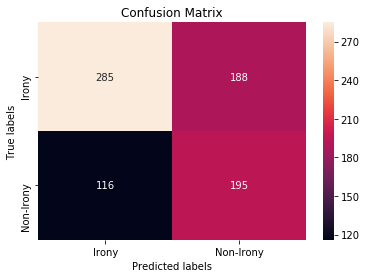

In [149]:
svm_cm = confusion_matrix(y_test, y_pred)
plotCM(svm_cm)

In [150]:
# cross-validation on train
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score

# Example of cross-validation
rf = RandomForestClassifier(n_estimators=10)

score = cross_val_score(rf, combined_df, y_train, cv=10, scoring = "accuracy")
print('CROSS VALIDATION')
print("Score:", score)
print("Mean:", score.mean())
print("std:", score.std())

rf.fit(combined_df, y_train)
y_pred = rf.predict(test_combined_df)
print(metrics.classification_report(y_test, y_pred, digits = 4))


CROSS VALIDATION
Score: [0.58441558 0.61979167 0.63020833 0.60052219 0.5848564  0.63968668
 0.58224543 0.61879896 0.5848564  0.54569191]
Mean: 0.599107354786206
std: 0.026816257884689297
              precision    recall  f1-score   support

           0     0.6895    0.6808    0.6851       473
           1     0.5237    0.5338    0.5287       311

    accuracy                         0.6224       784
   macro avg     0.6066    0.6073    0.6069       784
weighted avg     0.6237    0.6224    0.6230       784



In [153]:
feat_labels = list(combined_df)
for feature in zip(feat_labels, sorted(rf.feature_importances_)):
    print(feature)

('capitalisation', 0.03963061810719428)
('length', 0.056699918502077035)
('hashtag_word_ratio', 0.06159828508858917)
('# punctuation', 0.06930516625606536)
('positive_avg', 0.07807462278436059)
('neutral_avg', 0.0853583181136645)
('negative_avg', 0.09911111049943701)
('overall', 0.09952418480322398)
('ne_score', 0.11551122228172492)
('adv_score', 0.13486413295632058)
('adj_score', 0.16032242060734275)


In [152]:
np.sort(1,4,3)

TypeError: expected bytes, int found